In [29]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from treeinterpreter import treeinterpreter as ti
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.svm import SVR 
from sklearn.preprocessing import MinMaxScaler

In [30]:
# Read data from csv files
df_read = pd.read_csv(f'{os.getcwd()}/final_sentiment_price.csv', index_col="date")
df_read.rename(columns={'close':'Price'}, inplace=True)


# Scale the data to be between 0 and 1 using MinMaxScaler.fit_transform()
df_values = df_read.values
sc = MinMaxScaler()
data_scaled = sc.fit_transform(df_values)

# save the numpy array back in a dataframe
df_scaled = pd.DataFrame(data_scaled, columns=df_read.columns, index=df_read.index)

In [31]:
print(df_scaled.head())

                     Price   compund  positive  negative   neutral     score
date                                                                        
2022-02-27 11:00  0.279654  0.249013  0.175372  0.175760  0.831728  0.054112
2022-02-27 12:00  0.315670  0.259940  0.194975  0.231702  0.798011  0.765861
2022-02-27 13:00  0.222777  0.340078  0.275941  0.356191  0.683552  0.109916
2022-02-27 14:00  0.184608  0.193126  0.183451  0.515684  0.744426  0.130259
2022-02-27 15:00  0.261815  0.088741  0.184814  0.917395  0.649968  0.304134


In [44]:
# Predicting stock prices using Random Forest Regression model
def RandomForestModel(df):
    # Split data into training and testing sets
    train_start_index = 0
    train_end_index = int(len(df) * 0.6)
    test_start_index = train_end_index + 1
    test_end_index = len(df)

    train = df.iloc[train_start_index:train_end_index]
    test = df.iloc[test_start_index:test_end_index]

    # train, test = train_test_split(df, shuffle=False, test_size=0.2)
    # print(train.size)
    # print(test.size)

    sentiment_score_list_train = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'score']])
        sentiment_score_list_train.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list_train)

    sentiment_score_list_test = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'score']])
        sentiment_score_list_test.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list_test)

    y_train = pd.DataFrame(train['Price'])
    y_test = pd.DataFrame(test['Price'])

    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    rf.fit(numpy_df_train, y_train)
    prediction, bias, contributions = ti.predict(rf, numpy_df_test)

    # View accuracy of model on test data
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, prediction), 2))
    print('Mean Squared Error:', round(mean_squared_error(y_test, prediction), 2))
    print('RMSE (Root Mean Squared Error):', sqrt(mean_squared_error(y_test, prediction)))
    

    # Save the index for prediction_df as the index in the dataframe
    RF_prediction_df = pd.DataFrame(prediction, index=test.index)

    # Plot the prediction and actual values in the same graph 
    ax = RF_prediction_df.rename(columns={0: 'Predicted Price'}).plot(figsize=(15, 5), title='Random Forest Predicted Price', style='b-')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Stock Price Predicted')
    fig = y_test.rename(columns={'Price': 'Actual Price'}).plot(ax=ax, figsize=(15, 5), secondary_y=True, style='orange')
    fig.set_xlabel('Date and Time')
    fig.set_ylabel('Stock Price')
    plt.gcf().autofmt_xdate()
    plt.show()

    
    return RF_prediction_df, y_test


C:\Users\paulc\AppData\Local\Temp/ipykernel_26296/1194606524.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(numpy_df_train, y_train)


Mean Absolute Error: 2604.04
Mean Squared Error: 9178775.38
RMSE (Root Mean Squared Error): 3029.649382548611


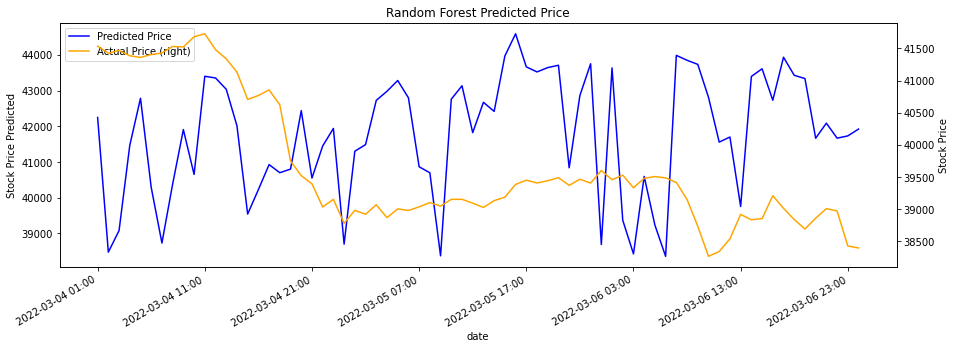

In [45]:
RF_prediction_df, RF_actual_df = RandomForestModel(df_read)




Percentage of positive sentiment: 16.68765075325368
Percentage of negative sentiment: 3.0079257770083396
Percentage of neutral sentiment: 80.30442346973798


[]

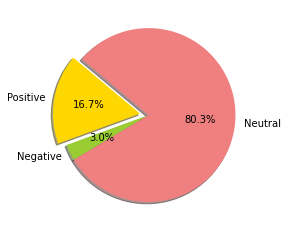

In [34]:
# Create a pie chart to show the percentage of positive and negative sentiment
positive_sentiment = df_read['positive'].sum()
negative_sentiment = df_read['negative'].sum()
neutral_sentiment = df_read['neutral'].sum()

# Percentage of positive sentiment
positive_sentiment_percentage = positive_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100
negative_sentiment_percentage = negative_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100
neutral_sentiment_percentage = neutral_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100

# Print the percentage of positive and negative sentiment
print("\n\n")
print("Percentage of positive sentiment:", positive_sentiment_percentage)
print("Percentage of negative sentiment:", negative_sentiment_percentage)
print("Percentage of neutral sentiment:", neutral_sentiment_percentage)

# Plot the pie chart 
labels = 'Positive', 'Negative', 'Neutral'
sizes = [positive_sentiment_percentage, negative_sentiment_percentage, neutral_sentiment_percentage]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.plot()

### SVM prediction

In [42]:
# Predicting stock prices using Support Vector Regression model
def SVRModel(df):
  # Split data into training and testing sets
  train_start_index = 0
  train_end_index = int(len(df) * 0.7)
  test_start_index = train_end_index + 1
  test_end_index = len(df)

  train = df.iloc[train_start_index:train_end_index]
  test = df.iloc[test_start_index:test_end_index]

  # df = pd.read_csv('sentimentAnalysis_' + stockname +'.csv')
  # train, test = train_test_split(df, shuffle=False, test_size=0.2)
  # print(train.size)
  # print(test.size)

  sentiment_score_list_train = []
  for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
    sentiment_score_list_train.append(sentiment_score)
  numpy_df_train = np.asarray(sentiment_score_list_train)

  sentiment_score_list_test = []
  for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
    sentiment_score_list_test.append(sentiment_score)
  numpy_df_test = np.asarray(sentiment_score_list_test)

  y_train = pd.DataFrame(train['Price'])
  y_test = pd.DataFrame(test['Price'])

  svr_rbf = SVR(kernel='rbf', C=1e6, gamma=0.1)
  svr_rbf.fit(numpy_df_train, y_train.values.flatten())
  output_test_svm = svr_rbf.predict(numpy_df_test)


  # Save the index for prediction_df as the index in the dataframe
  SVM_prediction_df = pd.DataFrame(output_test_svm, index=test.index)

  # Plot the prediction and actual values in the same graph 
  ax = SVM_prediction_df.rename(columns={0: 'Predicted Price'}).plot(figsize=(15, 5), title='SVM Predicted Price', style='b-')
  ax.set_xlabel('Date and Time')
  ax.set_ylabel('Stock Price Predicted')
  fig = y_test.rename(columns={'Price': 'Actual Price'}).plot(ax=ax, figsize=(15, 5), secondary_y=True, style='orange')
  fig.set_xlabel('Date and Time')
  fig.set_ylabel('Stock Price')
  plt.gcf().autofmt_xdate()
  plt.show()

  # Calculate the RMSE and MAE
  rmse = sqrt(mean_squared_error(y_test, output_test_svm))
  mae = mean_absolute_error(y_test, output_test_svm)

  # Print the RMSE and MAE
  print("\n\n")
  print("RMSE:", rmse)
  print("MAE:", mae)

  return SVM_prediction_df, y_test

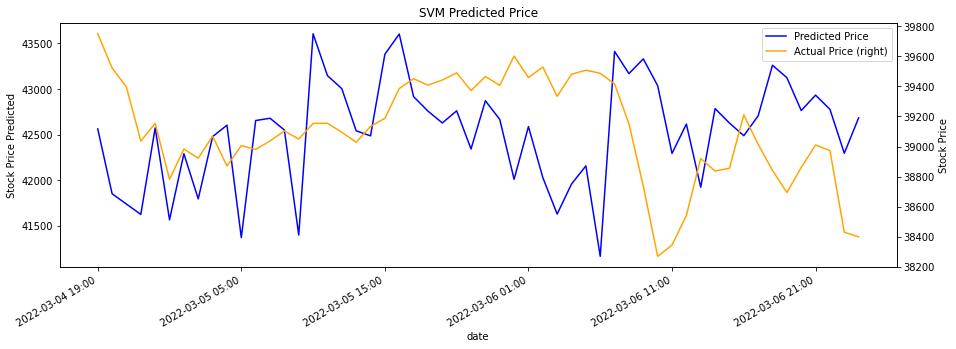




RMSE: 3487.553635255793
MAE: 3416.6884174032293


In [43]:
SVM_prediction_df, SVM_actual_df = SVRModel(df_read)

### Cross Correlation analysis

In [37]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

In [53]:
# Compute the cross correlation for RF predicted and actual price
RF_cross_corr = crosscorr(RF_prediction_df[0], RF_actual_df['Price'])

# Compute the cross correlation for SVM predicted and actual price
SVM_cross_corr = crosscorr(SVM_prediction_df[0], SVM_actual_df['Price'])

# Print out the Correlation for lag 0
print(f"Pearson CC for lag 0 for RF: {RF_cross_corr}")
print(f"Pearson CC for lag 0 for SVM: {SVM_cross_corr}")

Pearson CC for lag 0 for RF: -0.24028889911551285
Pearson CC for lag 0 for SVM: -0.12200872269786374


Lag that maximizes the correlation 0




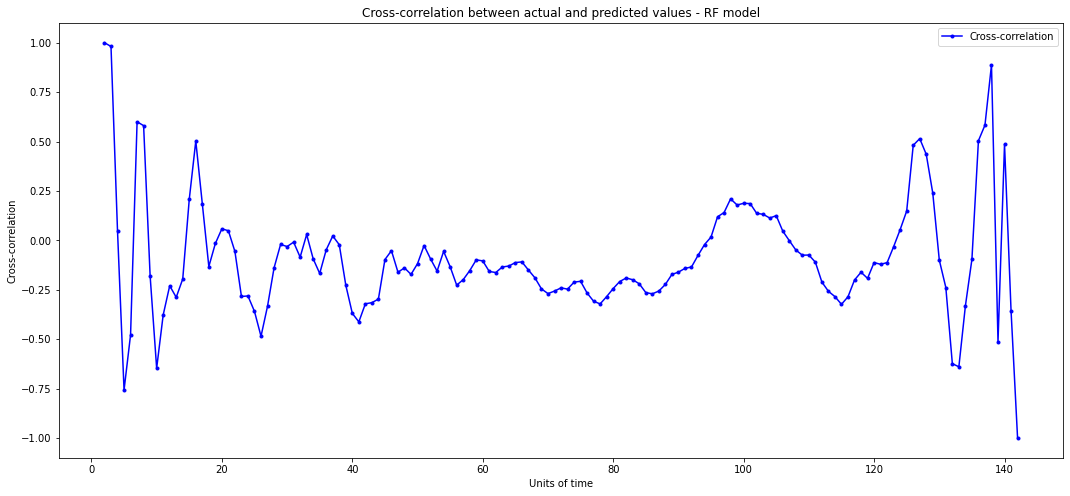

In [55]:
# Process of improving the CC value for RF 
xcov = [crosscorr(RF_prediction_df[0], RF_actual_df['Price'], lag=i, method="pearson") for i in range(-len(RF_actual_df['Price']), len(RF_actual_df['Price']))]

# Identify the lag that maximizes the correlation
lag_max = np.argmax(xcov)
print(f"Lag that maximizes the correlation {lag_max}\n\n")

plt.figure(figsize=(18,8))
plt.plot(xcov, '.-', color='blue', label='Cross-correlation', alpha=1)
plt.title("Cross-correlation between actual and predicted values - RF model")
plt.xlabel("Units of time")
plt.ylabel("Cross-correlation")
plt.legend()
plt.show()

Lag that maximizes the correlation 0




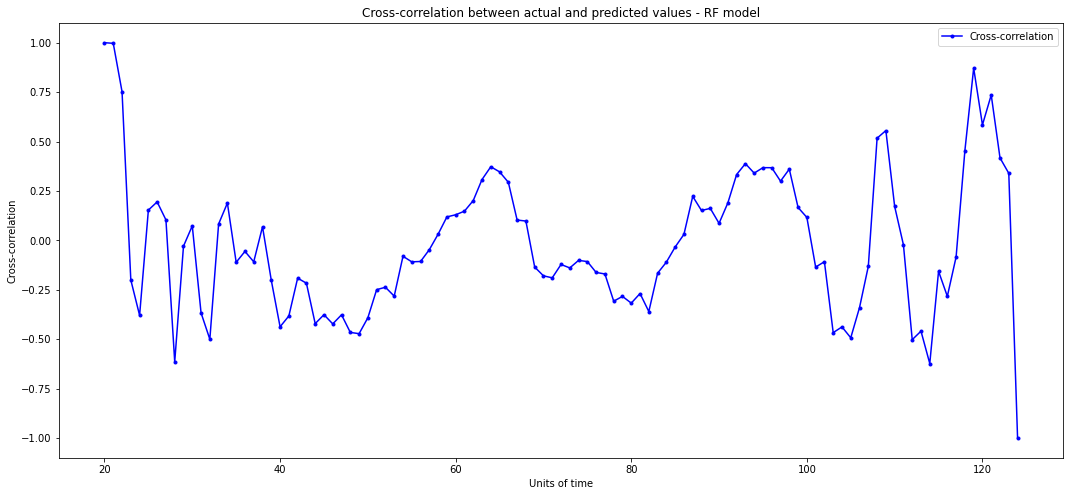

In [56]:
# Process of improving the CC value for SVM
xcov = [crosscorr(SVM_prediction_df[0], SVM_actual_df['Price'], lag=i, method="pearson") for i in range(-len(RF_actual_df['Price']), len(RF_actual_df['Price']))]

# Identify the lag that maximizes the correlation
lag_max = np.argmax(xcov)
print(f"Lag that maximizes the correlation {lag_max}\n\n")

plt.figure(figsize=(18,8))
plt.plot(xcov, '.-', color='blue', label='Cross-correlation', alpha=1)
plt.title("Cross-correlation between actual and predicted values - RF model")
plt.xlabel("Units of time")
plt.ylabel("Cross-correlation")
plt.legend()
plt.show()